This notebook contains the work-in-progress (WIP) scrap for the `imbed` project.

It is not meant to be run by all.


# word vectors

In [52]:
import numpy as np

# Note: This cosine similarity function only uses numpy arrays, so is dependency-light-weight.
#     Note tested for speed or memory though.
def cosine_similarity(u, v):
    """
    Computes the cosine similarity between two vectors or arrays of vectors.

    Args:
        u (array-like): A single vector (1D) or a 2D array (k x n),
                        where each row is a separate vector.
        v (array-like): A single vector (1D) or a 2D array (k x n).

    Returns:
        float or np.ndarray:
            - A float if both u and v are 1D vectors.
            - A 1D numpy array if either u or v is a 2D array.
    """
    # Convert to numpy arrays
    u = np.asarray(u)
    v = np.asarray(v)

    # Case 1: Both are single vectors
    if u.ndim == 1 and v.ndim == 1:
        dot_uv = np.dot(u, v)
        norm_u = np.linalg.norm(u)
        norm_v = np.linalg.norm(v)
        return dot_uv / (norm_u * norm_v)

    # Case 2: One is a single vector, the other is a 2D matrix
    if u.ndim == 1:
        # Turn u into shape (1, n)
        u = u[np.newaxis, :]
    if v.ndim == 1:
        # Turn v into shape (1, n)
        v = v[np.newaxis, :]

    # Now both u and v are 2D arrays. We want to compute row-wise similarities.
    # If one array has k rows and the other has m rows, row-wise dot products
    # across all pairs would yield a (k, m) matrix. But if typically you want
    # them to have the same number of rows or one has just 1 row, you can adjust
    # the code or usage. For now, let's assume each row in u is compared to the
    # corresponding row in v, which requires they have the same number of rows.

    # If you want each row in u to compare to the single row in v (i.e. v has shape (1, n)),
    # that will broadcast properly, giving a (k, n) array for u * v, summed along axis=1.

    # Dot products (row-wise)
    dot_uv = np.sum(u * v, axis=1)

    # Norms (row-wise)
    norm_u = np.linalg.norm(u, axis=1)
    norm_v = np.linalg.norm(v, axis=1)

    # Cosine similarity per row
    return dot_uv / (norm_u * norm_v)

In [53]:
u = [1, 2, 3]
v = [4, 5, 6]
print(cosine_similarity(u, v))  # Output: 0.9746318461970762

0.9746318461970762


In [54]:
u = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
v = [1, 0, 0]
print(cosine_similarity(u, v))  
# Output: [0.26726124 0.45584231 0.50257071]


[0.26726124 0.45584231 0.50257071]


In [48]:
from imbed import cosine_similarity

cosine_similarity(u, v)

0.9746318461970762

In [35]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

class EmbeddingKNN:
    def __init__(self, words, embeddings):
        """
        Initialize with:
          - words: list of w words
          - embeddings: np.array of shape (w, n), each row is an embedding.
        """
        self.words = words
        self.embeddings = embeddings

        # Fit Nearest Neighbors with up to 10 neighbors using cosine distance
        self.neigh = NearestNeighbors(n_neighbors=10, metric='cosine')
        self.neigh.fit(self.embeddings)

    def translation_neighbors(self, trans_vect, base_vecs=None):
        """
        For each vector in base_vecs (defaulting to self.embeddings), add trans_vect
        to the vector, then find the closest embedding in self.embeddings.

        :param trans_vect: A translation vector of shape (n,).
        :param base_vecs: A matrix of shape (m, n). If None, uses self.embeddings.
        :return: A list of (closest_word, cosine_distance) for each row of base_vecs.
        """
        if base_vecs is None:
            base_vecs = self.embeddings

        # Add trans_vect to each row of base_vecs
        translated_vecs = base_vecs + trans_vect

        # Query the nearest neighbor (n_neighbors=1) for each translated vector
        distances, indices = self.neigh.kneighbors(translated_vecs, n_neighbors=1)

        # Build the result (closest_word, distance)
        closest_word_list = []
        for i in range(len(translated_vecs)):
            idx = indices[i][0]       # The nearest neighbor index
            dist = distances[i][0]    # The cosine distance
            closest_word_list.append((self.words[idx], dist))

        return closest_word_list

In [2]:
src = '/Users/thorwhalen/Dropbox/_odata/figiri/wordnet_words/words_embeddings.parquet'

words = pd.read_parquet(src)
print(f"{words.shape=}")

words.shape=(52078, 1)


In [6]:
words.index.values[:10]

array(['a', 'aa', 'aaa', 'aachen', 'aah', 'aalborg', 'aalst', 'aalto',
       'aar', 'aardvark'], dtype=object)

In [3]:
word_vec = words.embedding.loc

all_words_vecs = np.vstack(words.embedding.values)
all_words_vecs.shape

(52078, 1536)

In [36]:
dacc = EmbeddingKNN(words.index.values, np.vstack(words.embedding.values))




In [ ]:
import heapq

data = [{'name': 'apple', 'value': 3}, {'name': 'banana', 'value': 1}, {'name': 'cherry', 'value': 2}]

# Find 2 items with smallest 'value'
smallest_by_value = heapq.nlargest(2, data, key=lambda x: x['value'])
print(smallest_by_value)  # Output: [{'name': 'banana', 'value': 1}, {'name': 'cherry', 'value': 2}]

[{'name': 'banana', 'value': 1}, {'name': 'cherry', 'value': 2}]


In [ ]:
import heapq

data = [{'name': 'apple', 'value': 3}, {'name': 'banana', 'value': 1}, {'name': 'cherry', 'value': 2}]

# Find 2 items with smallest 'value'
k = 10
smallest_by_value = heapq.nlargest(k, data, key=lambda x: cosine_similarity()
print(smallest_by_value)  # Output: [{'name': 'banana', 'value': 1}, {'name': 'cherry', 'value': 2}]

In [18]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def find_nearest_neighbors(target_vec, word_list, knn_model=None):
    """
    Finds the nearest neighbors of a given vector using the trained KNN model.

    Args:
        target_vec (np.ndarray): The target vector (n-dimensional).
        knn_model (NearestNeighbors): Trained sklearn KNN model.
        word_list (list): List of words corresponding to rows in the embedding matrix.

    Returns:
        list: List of tuples (word, distance) for the nearest neighbors.
    """
    if knn_model is None:
        raise ValueError("knn_model must be provided.")
    else:
        distances, indices = knn_model.kneighbors(target_vec.reshape(1, -1))
        neighbors = [(word_list[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
    return neighbors

In [ ]:
# Parameters
n_neighbors = 100  # Number of nearest neighbors to find

# Step 1: Train a NearestNeighbors model
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
knn.fit(all_words_vecs)


In [29]:
pairs = [
    ['man', 'woman'],
    ['boy', 'girl'],
    ['king', 'queen'],
    ['father', 'mother'],
    ['son', 'daughter'],
    ['brother', 'sister'],
    ['uncle', 'aunt'],
    ['nephew', 'niece'],
    ['husband', 'wife'],
    ['grandfather', 'grandmother'],
    ['grandson', 'granddaughter'],
    # ['he', 'she'],
    # ['his', 'her'],
    # ['him', 'her'],
]

trans_vecs = {(pair[0], pair[1]): word_vec[pair[1]] - word_vec[pair[0]] for pair in pairs}
vecs = np.array(list(trans_vecs.values()))
mean_vec = vecs.mean(axis=0)


In [37]:
t = dacc.translation_neighbors(mean_vec, all_words_vecs)

In [43]:
# make a pandas pandas dataframe with a word column and a distance column from this t

tt = pd.DataFrame(t, columns=['word', 'distance'])
tt.sort_values('distance', ascending=True, inplace=True)
tt

,word,distance
15375,englishwoman,0.059379
19042,gentlewoman,0.059601
488,actress,0.060443
25768,landlady,0.060760
25658,lady,0.061288
...,...,...
20576,handsome,0.100385
6479,businessman,0.100488
27797,man,0.100852
44356,strongman,0.101159


In [47]:
words.iloc[15375]

embedding    [0.03497309610247612, 0.003794316668063402, -0...
Name: englishwoman, dtype: object

In [21]:
nearest_neighbors = find_nearest_neighbors(mean_vec, words.index.values, knn, )


In [31]:
nearest_neighbors[:10]

[('englishwoman', 0.6488416364242586),
 ('gentlewoman', 0.6514492275017839),
 ('actress', 0.661357856802595),
 ('landlady', 0.6651019032417215),
 ('lady', 0.671341027828316),
 ('schoolgirl', 0.6742232729238721),
 ('goddaughter', 0.6776582926827888),
 ('womanhood', 0.681937009735876),
 ('girlhood', 0.6843100376626591),
 ('kinswoman', 0.6864297869414873)]

In [23]:
v = word_vec['emilia'] - word_vec['female'] + word_vec['male']
find_nearest_neighbors(v, knn, words.index.values)

[('emilia', 0.1856053348206207),
 ('amelia', 0.46806522773982784),
 ('melia', 0.49728034334623095),
 ('elisa', 0.5167585876760002),
 ('silvia', 0.5349300795158866),
 ('molise', 0.5359479139491025),
 ('selma', 0.5632534638477151),
 ('ma', 0.5637456101948137),
 ('camelia', 0.5658067890279446),
 ('emile', 0.5695956263111385),
 ('ela', 0.5700265779662446),
 ('milord', 0.5701551230167076),
 ('arminius', 0.5704029512850921),
 ('parmelia', 0.5727260735708704),
 ('abelia', 0.5812744010549296),
 ('minerva', 0.5818079692613954),
 ('maia', 0.5836960554181392),
 ('carmine', 0.5897216682569613),
 ('romulus', 0.5902641981276877),
 ('male', 0.5916144864350306),
 ('lena', 0.5979485698736845),
 ('anna', 0.5981072501945826),
 ('mare', 0.5991993418873663),
 ('noemi', 0.6018002615988873),
 ('pomelo', 0.6031528296288499),
 ('malvasia', 0.6052748010527991),
 ('murillo', 0.605366251841285),
 ('attilio', 0.6054655484089878),
 ('elm', 0.6068193034487999),
 ('ermine', 0.6071094397610399),
 ('emu', 0.60719925683

In [61]:
# average cosine similarity between mean_vec and the vecs
from imbed import cosine_similarity

mean_similarity_of_targets = np.mean([cosine_similarity(mean_vec, vec) for vec in vecs])
mean_similarity_of_targets

0.6086880638995171

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

# Compute cosine distances
cosine_distances = cdist(all_words_vecs, mean_vec.reshape(1, -1), metric='cosine').flatten()

cosine_distances.shape

(52078,)

In [27]:
from imbed import cosine_similarity

cosine_similarity(word_vec['emilia'], word_vec['amelia'])

0.6685385560757456

In [ ]:
# average cosine similarity between mean_vec and the vecs
from imbed import cosine_similarity

mean_similarity_of_targets = np.mean([cosine_similarity(mean_vec, vec) for vec in vecs])
mean_similarity_of_other_words = np.mean([cosine_similarity(mean_vec, vec) for vec in vecs])

In [ ]:
t = all_words_vecs[0]
all_words_vecs[:10]
cosine_similarity(t, all_words_vecs)

0.7395650570848009

# The k-d to 2-d problem

After embedding your objects of interest into k-dimensional vectors, you might further embed them into two or three dimensions for visualization. This process inevitably loses some information and introduces distortions, but it's still valuable. The initial conversion of texts or images into numerical vectors also involved information loss, yet it was useful for your specific goals.

Dimensionality reduction typically results in losing some details. The key is to preserve the essential information (the "signal") and minimize the loss of less important details (the "noise"). Done well, this can be beneficial, especially if it enhances the signal-to-noise ratio.

This principle also applies to compressing vectors for visualization. The aim is to present complex data usefully and intuitively, enabling analysts to spot patterns and gain insights. It's a balance between maintaining utility and practical implementation when transforming k-dimensional data into two-dimensional forms.



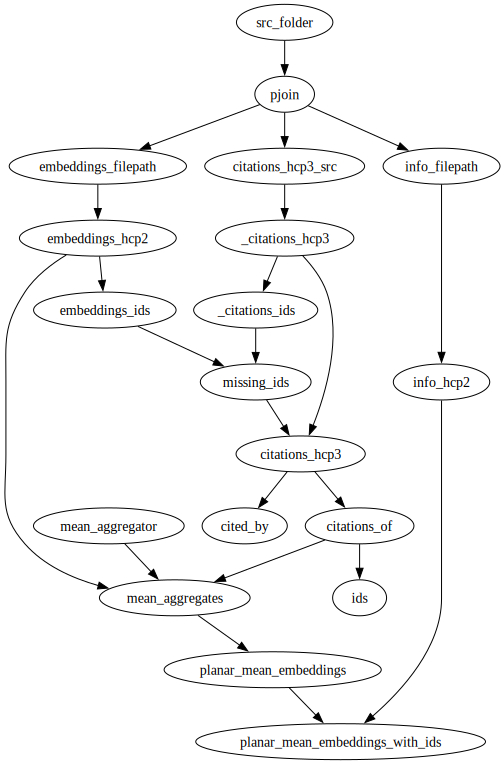

In [18]:
from i2.footprints import attribute_dependencies, init_argument_names
from imbed.mdat.hcp import Hcp3Dacc
from meshed.itools import graphviz_digraph

deps = dict(attribute_dependencies(Hcp3Dacc))

graphviz_digraph(deps)


In [24]:
rootdir = '/Users/thorwhalen/Dropbox/_odata/figiri/hcp'
dacc = Hcp3Dacc(rootdir)

In [25]:
t = dacc.citations_and_titles
print(f"{len(dacc.info_hcp2)=}, {len(dacc.citations_of)}, {dacc.citations_and_titles.shape=}")
t.head()

len(dacc.info_hcp2)=354165, 308135, dacc.citations_and_titles.shape=(308135, 3)


,cited_ids,id,title
0,"[2138790588, 2013150886]",245658,Standardized low-resolution brain electromagne...
2,"[1994893189, 2158553737, 1604916109, 202841896...",718838,Pathophysiology of obsessiveâcompulsive diso...
4,"[2114205159, 2161774890, 1965693998, 211020414...",831416,Remote Ischemic Preconditioning Provides Early...
5,"[2025976960, 2172013173]",898828,The Unknown Mechanism of the Overtraining Synd...
6,"[2138019504, 2127271355, 2103972604]",905619,Revisiting Frank-Wolfe: Projection-Free Sparse...


# Appendix: Speed comparison between numpy and scipy cosine distance

In [75]:
import numpy as np

def cosine_similarity(u, v, *, cartesian_product=False):
    """
    Computes the cosine similarity between two vectors or arrays of vectors.

    If both inputs are 1D vectors, returns a float.
    If one or both inputs are 2D arrays, returns either a 1D array (row-wise)
    or a 2D array (cartesian product of rows) depending on the cartesian_product flag.

    Args:
        u (array-like): A single vector (1D) or a 2D array (k x n),
                        where each row is a separate vector.
        v (array-like): A single vector (1D) or a 2D array (k x n).
        cartesian_product (bool, optional):
            - If False (default), the function compares rows in a one-to-one fashion.
              Expects the same number of rows in u and v.
            - If True, computes the similarity for every combination of rows
              (results in a 2D array).

    Returns:
        float or np.ndarray:
            - A float if both u and v are 1D vectors.
            - A 1D numpy array if either u or v is a 2D array and cartesian_product=False.
            - A 2D numpy array if cartesian_product=True.

    Raises:
        ValueError: If the number of columns in u and v do not match,
                    or if (cartesian_product=False) but u and v have different row counts.
    """
    u = np.asarray(u)
    v = np.asarray(v)

    # -----------------------------
    # Case 1: Both are single 1D vectors
    # -----------------------------
    if u.ndim == 1 and v.ndim == 1:
        if u.shape[0] != v.shape[0]:
            raise ValueError("Vectors u and v must have the same dimension.")
        dot_uv = np.dot(u, v)
        norm_u = np.linalg.norm(u)
        norm_v = np.linalg.norm(v)
        return dot_uv / (norm_u * norm_v)

    # -----------------------------
    # Case 2: At least one is 2D
    # Ensure both are 2D
    # -----------------------------
    if u.ndim == 1:  # shape (n,) -> (1, n)
        u = u[np.newaxis, :]
    if v.ndim == 1:  # shape (n,) -> (1, n)
        v = v[np.newaxis, :]

    # Now u.shape = (k1, n1), v.shape = (k2, n2)
    k1, n1 = u.shape
    k2, n2 = v.shape

    # Validate the number of columns (dimensions)
    if n1 != n2:
        raise ValueError(
            f"Inconsistent dimensions: u has {n1} columns, v has {n2} columns."
        )

    # -----------------------------
    # Non-cartesian (row-wise) vs cartesian product
    # -----------------------------
    if not cartesian_product:
        # Requires the same number of rows in u and v
        if k1 != k2:
            raise ValueError(
                f"For row-wise comparison, u and v must have the same number of rows. "
                f"(u has {k1}, v has {k2})"
            )

        # Row-wise dot products
        dot_uv = np.sum(u * v, axis=1)   # shape (k1,)
        norm_u = np.linalg.norm(u, axis=1)  # shape (k1,)
        norm_v = np.linalg.norm(v, axis=1)  # shape (k1,)
        return dot_uv / (norm_u * norm_v)
    else:
        # Cartesian product: compute similarity for all row combinations
        # dot_uv will have shape (k1, k2)
        dot_uv = u @ v.T
        # Norms for each row in u (shape (k1,)) and v (shape (k2,))
        norm_u = np.linalg.norm(u, axis=1)
        norm_v = np.linalg.norm(v, axis=1)
        # Outer product of norms to match (k1, k2)
        denom = np.outer(norm_u, norm_v)
        return dot_uv / denom
    

import numpy as np

# Single 1D vectors
u_1d = [1, 2, 3]
v_1d = [4, 5, 6]
print(cosine_similarity(u_1d, v_1d))  # ~0.9746

# Row-wise 2D
u_2d = np.array([[1, 2], [3, 4]])
v_2d = np.array([[5, 6], [7, 8]])
print(cosine_similarity(u_2d, v_2d, cartesian_product=False))
# array of length 2 (row-wise comparisons)

# Cartesian product
print(cosine_similarity(u_2d, v_2d, cartesian_product=True))
# 2D array (2x2), each element is similarity of row i from u_2d with row j from v_2d

0.9746318461970762
[0.97341717 0.99716412]
[[0.97341717 0.96761727]
 [0.99868766 0.99716412]]


In [76]:
import numpy as np


def cosine_similarity(u, v, *, cartesian_product=False):
    """
    Computes the cosine similarity between two vectors or arrays of vectors.

    If both inputs are 1D vectors, returns a float.
    If one or both inputs are 2D arrays, returns either a 1D array (row-wise)
    or a 2D array (cartesian product of rows) depending on the cartesian_product flag.

    Behavior for row-wise (cartesian_product=False):
      - If both arrays have the same number of rows, compares row i of u to row i of v.
      - If one array has only 1 row, it is broadcast against each row of the other array.
        (Returns a 1D array of length k, where k is the number of rows in the multi-row array.)

    Args:
        u (array-like): A single vector (1D) or a 2D array (k1 x n),
                        where each row is a separate vector.
        v (array-like): A single vector (1D) or a 2D array (k2 x n).
        cartesian_product (bool, optional):
            - If False (default), the function compares rows in a one-to-one fashion (u[i] vs. v[i]),
              **except** if one array has exactly 1 row and the other has multiple rows, in which case
              that single row is broadcast to all rows of the other array.
            - If True, computes the similarity for every combination of rows
              (results in a 2D array of shape (k1, k2)).

    Returns:
        float or np.ndarray:
            - A float if both u and v are 1D vectors.
            - A 1D numpy array if either u or v is 2D and cartesian_product=False.
            - A 2D numpy array if cartesian_product=True.

    Raises:
        ValueError:
            - If the number of columns in u and v do not match.
            - If cartesian_product=False, both arrays have multiple rows but differ in row count.

    Examples
    --------

    # --- Case 1: Both are single 1D vectors
    >>> u1d = [2, 0]
    >>> v1d = [2, 0]
    >>> cosine_similarity(u1d, v1d)
    1.0

    # --- Case 2: Single 1D vector vs. a 2D array (row-wise broadcast)
    >>> import numpy as np
    >>> M1 = np.array([
    ...     [2, 0],
    ...     [0, 2],
    ...     [2, 2]
    ... ])
    >>> res2 = cosine_similarity(u1d, M1)
    >>> res2  # doctest: +ELLIPSIS
    array([1.        , 0.        , 0.70710678...])

    # --- Case 3: Two 2D arrays of different row lengths, cartesian_product=False (raises ValueError)
    >>> M2_different = np.array([
    ...     [0, 2],
    ...     [2, 2]
    ... ])
    >>> # Expect a ValueError because M1 has 3 rows and M2_different has 2 rows
    >>> cosine_similarity(M1, M2_different, cartesian_product=False)  # doctest: +IGNORE_EXCEPTION_DETAIL
    Traceback (most recent call last):
        ...
    ValueError: For row-wise comparison, u and v must have the same number of rows...

    # --- Case 4: Two 2D arrays of the same number of rows, cartesian_product=False
    >>> M2 = np.array([
    ...     [0, 2],
    ...     [2, 0],
    ...     [2, 2]
    ... ])
    >>> res4 = cosine_similarity(M1, M2, cartesian_product=False)
    >>> res4
    array([0., 0., 1.])

    # --- Case 5: Two 2D arrays of the same size, cartesian_product=True
    # (computes every combination of rows => 3 x 3)
    >>> res5 = cosine_similarity(M1, M2, cartesian_product=True)
    >>> np.round(res5, 3)  # doctest: +NORMALIZE_WHITESPACE
    array([[0.   , 1.   , 0.707],
           [1.   , 0.   , 0.707],
           [0.707, 0.707, 1.   ]])
    """
    # Convert inputs to numpy arrays
    u = np.asarray(u)
    v = np.asarray(v)

    # --------------- CASE 1: Both are single 1D vectors ---------------
    if u.ndim == 1 and v.ndim == 1:
        if u.shape[0] != v.shape[0]:
            raise ValueError("Vectors u and v must have the same dimension.")
        dot_uv = np.dot(u, v)
        norm_u = np.linalg.norm(u)
        norm_v = np.linalg.norm(v)
        return dot_uv / (norm_u * norm_v)

    # --------------- CASE 2: At least one is 2D; ensure both are 2D ---------------
    if u.ndim == 1:  # shape (n,) -> (1, n)
        u = u[np.newaxis, :]
    if v.ndim == 1:  # shape (n,) -> (1, n)
        v = v[np.newaxis, :]

    k1, n1 = u.shape
    k2, n2 = v.shape

    # Check that columns (vector dimension) match
    if n1 != n2:
        raise ValueError(
            f"Inconsistent dimensions: u has {n1} columns, v has {n2} columns."
        )

    # --------------- CARTESIAN PRODUCT ---------------
    if cartesian_product:
        # (k1 x k2) dot products
        dot_uv = u @ v.T  # shape (k1, k2)
        norm_u = np.linalg.norm(u, axis=1)  # shape (k1,)
        norm_v = np.linalg.norm(v, axis=1)  # shape (k2,)
        # Outer product of norms => shape (k1, k2)
        denom = np.outer(norm_u, norm_v)
        return dot_uv / denom

    # --------------- ROW-WISE (NOT CARTESIAN) ---------------
    # 1) If one array has a single row (k=1), broadcast it against each row of the other
    if k1 == 1 and k2 > 1:
        # Broadcast u's single row against each row in v
        dot_uv = np.sum(u[0] * v, axis=1)  # shape (k2,)
        norm_u = np.linalg.norm(u[0])  # scalar
        norm_v = np.linalg.norm(v, axis=1)  # shape (k2,)
        return dot_uv / (norm_u * norm_v)

    if k2 == 1 and k1 > 1:
        # Broadcast v's single row against each row in u
        dot_uv = np.sum(u * v[0], axis=1)  # shape (k1,)
        norm_u = np.linalg.norm(u, axis=1)  # shape (k1,)
        norm_v = np.linalg.norm(v[0])  # scalar
        return dot_uv / (norm_u * norm_v)

    # 2) Otherwise, require the same number of rows
    if k1 != k2:
        raise ValueError(
            f"For row-wise comparison, u and v must have the same number of rows. "
            f"(u has {k1}, v has {k2})"
        )
    dot_uv = np.sum(u * v, axis=1)  # shape (k1,)
    norm_u = np.linalg.norm(u, axis=1)
    norm_v = np.linalg.norm(v, axis=1)
    return dot_uv / (norm_u * norm_v)


import numpy as np
from scipy.spatial.distance import cosine, cdist


def cosine_similarity_scipy(u, v, *, cartesian_product=False):
    """
    Computes the cosine similarity between two vectors or arrays of vectors,
    using SciPy's distance functions under the hood.

    - If both inputs are 1D vectors, returns a float.
    - If one or both inputs are 2D arrays, returns either a 1D array (row-wise)
      or a 2D array (cartesian product of rows) depending on the
      `cartesian_product` flag.

    Behavior for row-wise (cartesian_product=False):
      - If both arrays have the same number of rows (k), compares row i of u
        with row i of v, resulting in a 1D array of length k.
      - If one array has shape (1, d) and the other has shape (k, d), the single
        row is broadcast to all k rows of the other array, returning a 1D array
        of length k.
      - Otherwise, raises a ValueError if row counts are incompatible.

    Behavior for cartesian_product=True:
      - Computes the similarity for every combination of rows in u and v,
        returning a 2D array of shape (k1, k2).

    Args:
        u (array-like): A single vector (1D) or a 2D array (k1 x d),
                        where each row is a separate vector.
        v (array-like): A single vector (1D) or a 2D array (k2 x d).
        cartesian_product (bool, optional):
            If True, computes a 2D matrix of size (k1, k2) for all pairs of rows.
            If False, performs row-wise comparisons or broadcasting
            as described above.

    Returns:
        float or np.ndarray:
            - A float if both u and v are 1D vectors.
            - A 1D NumPy array if either u or v is 2D and cartesian_product=False.
            - A 2D NumPy array if cartesian_product=True.

    Raises:
        ValueError:
            - If the number of columns (dimensions) in u and v do not match.
            - If cartesian_product=False and row counts are incompatible.

    Notes:
        Internally, uses:
         - `scipy.spatial.distance.cosine(u, v)` for single 1D vectors.
         - `scipy.spatial.distance.cdist(u, v, metric="cosine")` for multi-row data,
           then converts distances to similarity via `1 - distance`.

    Examples
    --------
    >>> # Single 1D vectors
    >>> u1d = [2, 0]
    >>> v1d = [2, 0]
    >>> cosine_similarity_scipy(u1d, v1d)
    1.0

    >>> # Single 1D vector vs. 2D array (row-wise broadcast)
    >>> import numpy as np
    >>> M1 = np.array([
    ...     [2, 0],
    ...     [0, 2],
    ...     [2, 2]
    ... ])
    >>> res2 = cosine_similarity_scipy(u1d, M1)
    >>> np.round(res2, 3)
    array([1.   , 0.   , 0.707])

    >>> # Two 2D arrays of different row lengths, cartesian_product=False
    >>> M2_different = np.array([
    ...     [0, 2],
    ...     [2, 2]
    ... ])
    >>> # Expect a ValueError if we try row-wise with mismatched rows
    >>> cosine_similarity_scipy(M1, M2_different, cartesian_product=False)  # doctest: +IGNORE_EXCEPTION_DETAIL
    Traceback (most recent call last):
      ...
    ValueError: ...

    >>> # Two 2D arrays of the same row length (row-wise)
    >>> M2 = np.array([
    ...     [0, 2],
    ...     [2, 0],
    ...     [2, 2]
    ... ])
    >>> res4 = cosine_similarity_scipy(M1, M2, cartesian_product=False)
    >>> res4
    array([0., 0., 1.])

    >>> # Cartesian product of all row pairs => (3 x 3) matrix
    >>> res5 = cosine_similarity_scipy(M1, M2, cartesian_product=True)
    >>> np.round(res5, 3)
    array([[0.   , 1.   , 0.707],
           [1.   , 0.   , 0.707],
           [0.707, 0.707, 1.   ]])
    """
    u = np.asarray(u)
    v = np.asarray(v)

    # ----- CASE 1: Both are single 1D vectors -----
    if u.ndim == 1 and v.ndim == 1:
        if u.shape[0] != v.shape[0]:
            raise ValueError("Vectors u and v must have the same dimension.")
        # Cosine distance => 1 - similarity
        dist = cosine(u, v)
        return 1.0 - dist

    # ----- CASE 2: At least one is 2D; ensure both are 2D -----
    if u.ndim == 1:
        u = u[np.newaxis, :]  # (1, d)
    if v.ndim == 1:
        v = v[np.newaxis, :]  # (1, d)

    k1, d1 = u.shape
    k2, d2 = v.shape

    if d1 != d2:
        raise ValueError(
            f"Inconsistent dimensions: u has {d1} columns, v has {d2} columns."
        )

    # ----- CARTESIAN PRODUCT -----
    if cartesian_product:
        # cdist => shape (k1, k2)
        dist_matrix = cdist(u, v, metric="cosine")
        return 1.0 - dist_matrix

    # ----- ROW-WISE (NOT CARTESIAN) -----
    # If either array has 1 row, broadcast it against the rows of the other
    if k1 == 1 and k2 > 1:
        # => shape (1, k2)
        dist_matrix = cdist(u, v, metric="cosine")
        # flatten => shape (k2,)
        return 1.0 - dist_matrix.ravel()

    if k2 == 1 and k1 > 1:
        # => shape (k1, 1)
        dist_matrix = cdist(u, v, metric="cosine")
        # flatten => shape (k1,)
        return 1.0 - dist_matrix.ravel()

    # Otherwise, require that k1 == k2
    if k1 != k2:
        raise ValueError(
            f"For row-wise comparison, u and v must have the same number of rows. "
            f"(u has {k1}, v has {k2})"
        )

    # cdist => shape (k1, k1)
    dist_matrix = cdist(u, v, metric="cosine")
    # Row-wise => take diagonal => shape (k1,)
    diag_distances = np.diag(dist_matrix)
    return 1.0 - diag_distances


import numpy as np
import timeit


def test_cosine_similarity_performance(
    *,
    numpy_func=cosine_similarity,
    scipy_func=cosine_similarity_scipy,
    repeats=5,
    number=5,
    verbose=True,
):
    """
    Compares the performance of two cosine similarity functions (NumPy and SciPy)
    under various scenarios.

    Args:
        numpy_func (callable): The NumPy-based cosine similarity function.
        scipy_func (callable): The SciPy-based cosine similarity function.
        repeats (int): How many times to repeat each timing scenario (timeit 'repeat').
        number (int): How many times to run the timed operation per repeat (timeit 'number').
        verbose (bool): Whether to print a summary of the results.

    Returns:
        dict: A nested dictionary containing timing results for each test scenario.
              Example structure:
              {
                  "single_1d": {"numpy_time": ..., "scipy_time": ...},
                  "one_row_vs_multi": {...},
                  "row_wise_equal_rows": {...},
                  "cartesian_product": {...}
              }
    """

    # ------------------------------------------------
    # Test Data
    # ------------------------------------------------

    # 1) Single 1D vectors (dimension = 512)
    u_1d = np.random.rand(512)
    v_1d = np.random.rand(512)

    # 2) One-row vs. multi-row (for row-wise broadcast)
    #    e.g. shape (1, 512) vs. shape (1000, 512)
    u_one_row = np.random.rand(1, 512)
    v_multi = np.random.rand(1000, 512)

    # 3) Row-wise with equal rows
    #    e.g. shape (2000, 256) each
    u_equal = np.random.rand(2000, 256)
    v_equal = np.random.rand(2000, 256)

    # 4) Cartesian product with moderately sized arrays
    #    shape (800, 256) each => result is (800 x 800) distance matrix
    u_cart = np.random.rand(800, 256)
    v_cart = np.random.rand(800, 256)

    # ------------------------------------------------
    # Helper function to measure a scenario
    # ------------------------------------------------
    def measure_time(stmt, globals_dict):
        """
        Measures execution time of `stmt` using the timeit.repeat function,
        returns the best timing out of 'repeats' repeats, each doing 'number' runs.
        """
        times = timeit.repeat(stmt, repeat=repeats, number=number, globals=globals_dict)
        best_time = min(times) / number  # average time per run
        return best_time

    results = {}

    # ------------------------------------------------
    # Single 1D vectors
    # ------------------------------------------------
    globals_single_1d = {
        "u": u_1d,
        "v": v_1d,
        "numpy_func": numpy_func,
        "scipy_func": scipy_func,
    }
    numpy_time = measure_time("numpy_func(u, v)", globals_single_1d)
    scipy_time = measure_time("scipy_func(u, v)", globals_single_1d)
    results["single_1d"] = {
        "numpy_time": numpy_time,
        "scipy_time": scipy_time,
    }

    # ------------------------------------------------
    # One-row vs. multi-row
    # ------------------------------------------------
    globals_one_vs_multi = {
        "u": u_one_row,
        "v": v_multi,
        "numpy_func": numpy_func,
        "scipy_func": scipy_func,
    }
    numpy_time = measure_time(
        "numpy_func(u, v, cartesian_product=False)", globals_one_vs_multi
    )
    scipy_time = measure_time(
        "scipy_func(u, v, cartesian_product=False)", globals_one_vs_multi
    )
    results["one_row_vs_multi"] = {
        "numpy_time": numpy_time,
        "scipy_time": scipy_time,
    }

    # ------------------------------------------------
    # Row-wise with equal rows
    # ------------------------------------------------
    globals_equal_rows = {
        "u": u_equal,
        "v": v_equal,
        "numpy_func": numpy_func,
        "scipy_func": scipy_func,
    }
    numpy_time = measure_time(
        "numpy_func(u, v, cartesian_product=False)", globals_equal_rows
    )
    scipy_time = measure_time(
        "scipy_func(u, v, cartesian_product=False)", globals_equal_rows
    )
    results["row_wise_equal_rows"] = {
        "numpy_time": numpy_time,
        "scipy_time": scipy_time,
    }

    # ------------------------------------------------
    # Cartesian product
    # ------------------------------------------------
    globals_cart = {
        "u": u_cart,
        "v": v_cart,
        "numpy_func": numpy_func,
        "scipy_func": scipy_func,
    }
    numpy_time = measure_time("numpy_func(u, v, cartesian_product=True)", globals_cart)
    scipy_time = measure_time("scipy_func(u, v, cartesian_product=True)", globals_cart)
    results["cartesian_product"] = {
        "numpy_time": numpy_time,
        "scipy_time": scipy_time,
    }

    if verbose:
        print("\n=== Performance Comparison: NumPy vs. SciPy ===")
        for scenario, times in results.items():
            print(f"\nScenario: {scenario}")
            print(
                f"  NumPy time: {times['numpy_time']:.5f} seconds/run (best of {repeats})"
            )
            print(
                f"  SciPy time: {times['scipy_time']:.5f} seconds/run (best of {repeats})"
            )

    return results


test_cosine_similarity_performance()


=== Performance Comparison: NumPy vs. SciPy ===

Scenario: single_1d
  NumPy time: 0.00001 seconds/run (best of 5)
  SciPy time: 0.00001 seconds/run (best of 5)

Scenario: one_row_vs_multi
  NumPy time: 0.00094 seconds/run (best of 5)
  SciPy time: 0.00115 seconds/run (best of 5)

Scenario: row_wise_equal_rows
  NumPy time: 0.00155 seconds/run (best of 5)
  SciPy time: 0.91469 seconds/run (best of 5)

Scenario: cartesian_product
  NumPy time: 0.00603 seconds/run (best of 5)
  SciPy time: 0.14682 seconds/run (best of 5)


{'single_1d': {'numpy_time': 1.2133398558944464e-05,
  'scipy_time': 1.3966800179332494e-05},
 'one_row_vs_multi': {'numpy_time': 0.0009408915997482836,
  'scipy_time': 0.0011457418091595172},
 'row_wise_equal_rows': {'numpy_time': 0.0015512250014580787,
  'scipy_time': 0.9146882999921218},
 'cartesian_product': {'numpy_time': 0.006034700002055615,
  'scipy_time': 0.1468225166085176}}

In [ ]:

def cosine_similarity(u, v, *, cartesian_product=False):
    """
    Computes the cosine similarity between two vectors or arrays of vectors.

    If both inputs are 1D vectors, returns a float.
    If one or both inputs are 2D arrays, returns either a 1D array (row-wise)
    or a 2D array (cartesian product of rows) depending on the cartesian_product flag.

    Behavior for row-wise (cartesian_product=False):
      - If both arrays have the same number of rows, compares row i of u to row i of v.
      - If one array has only 1 row, it is broadcast against each row of the other array.
        (Returns a 1D array of length k, where k is the number of rows in the multi-row array.)

    Note: This function only uses numpy.

    Args:
        u (array-like): A single vector (1D) or a 2D array (k1 x n),
                        where each row is a separate vector.
        v (array-like): A single vector (1D) or a 2D array (k2 x n).
        cartesian_product (bool, optional):
            - If False (default), the function compares rows in a one-to-one fashion (u[i] vs. v[i]),
              **except** if one array has exactly 1 row and the other has multiple rows, in which case
              that single row is broadcast to all rows of the other array.
            - If True, computes the similarity for every combination of rows
              (results in a 2D array of shape (k1, k2)).

    Returns:
        float or np.ndarray:
            - A float if both u and v are 1D vectors.
            - A 1D numpy array if either u or v is 2D and cartesian_product=False.
            - A 2D numpy array if cartesian_product=True.

    Raises:
        ValueError:
            - If the number of columns in u and v do not match.
            - If cartesian_product=False, both arrays have multiple rows but differ in row count.

    Examples
    --------

    # --- Case 1: Both are single 1D vectors
    >>> u1d = [2, 0]
    >>> v1d = [2, 0]
    >>> cosine_similarity(u1d, v1d)
    1.0

    # --- Case 2: Single 1D vector vs. a 2D array (row-wise broadcast)
    >>> import numpy as np
    >>> M1 = np.array([
    ...     [2, 0],
    ...     [0, 2],
    ...     [2, 2]
    ... ])
    >>> res2 = cosine_similarity(u1d, M1)
    >>> res2  # doctest: +ELLIPSIS
    array([1.        , 0.        , 0.70710678...])

    # --- Case 3: Two 2D arrays of different row lengths, cartesian_product=False (raises ValueError)
    >>> M2_different = np.array([
    ...     [0, 2],
    ...     [2, 2]
    ... ])
    >>> # Expect a ValueError because M1 has 3 rows and M2_different has 2 rows
    >>> cosine_similarity(M1, M2_different, cartesian_product=False)  # doctest: +IGNORE_EXCEPTION_DETAIL
    Traceback (most recent call last):
        ...
    ValueError: For row-wise comparison, u and v must have the same number of rows...

    # --- Case 4: Two 2D arrays of the same number of rows, cartesian_product=False
    >>> M2 = np.array([
    ...     [0, 2],
    ...     [2, 0],
    ...     [2, 2]
    ... ])
    >>> res4 = cosine_similarity(M1, M2, cartesian_product=False)
    >>> res4
    array([0., 0., 1.])

    # --- Case 5: Two 2D arrays of the same size, cartesian_product=True
    # (computes every combination of rows => 3 x 3)
    >>> res5 = cosine_similarity(M1, M2, cartesian_product=True)
    >>> np.round(res5, 3)  # doctest: +NORMALIZE_WHITESPACE
    array([[0.   , 1.   , 0.707],
           [1.   , 0.   , 0.707],
           [0.707, 0.707, 1.   ]])
    """
    # Convert inputs to numpy arrays
    u = np.asarray(u)
    v = np.asarray(v)

    # --------------- CASE 1: Both are single 1D vectors ---------------
    if u.ndim == 1 and v.ndim == 1:
        if u.shape[0] != v.shape[0]:
            raise ValueError("Vectors u and v must have the same dimension.")
        dot_uv = np.dot(u, v)
        norm_u = np.linalg.norm(u)
        norm_v = np.linalg.norm(v)
        return dot_uv / (norm_u * norm_v)

    # --------------- CASE 2: At least one is 2D; ensure both are 2D ---------------
    if u.ndim == 1:  # shape (n,) -> (1, n)
        u = u[np.newaxis, :]
    if v.ndim == 1:  # shape (n,) -> (1, n)
        v = v[np.newaxis, :]

    k1, n1 = u.shape
    k2, n2 = v.shape

    # Check that columns (vector dimension) match
    if n1 != n2:
        raise ValueError(
            f"Inconsistent dimensions: u has {n1} columns, v has {n2} columns."
        )

    # --------------- CARTESIAN PRODUCT ---------------
    if cartesian_product:
        # (k1 x k2) dot products
        dot_uv = u @ v.T  # shape (k1, k2)
        norm_u = np.linalg.norm(u, axis=1)  # shape (k1,)
        norm_v = np.linalg.norm(v, axis=1)  # shape (k2,)
        # Outer product of norms => shape (k1, k2)
        denom = np.outer(norm_u, norm_v)
        return dot_uv / denom

    # --------------- ROW-WISE (NOT CARTESIAN) ---------------
    # 1) If one array has a single row (k=1), broadcast it against each row of the other
    if k1 == 1 and k2 > 1:
        # Broadcast u's single row against each row in v
        dot_uv = np.sum(u[0] * v, axis=1)  # shape (k2,)
        norm_u = np.linalg.norm(u[0])  # scalar
        norm_v = np.linalg.norm(v, axis=1)  # shape (k2,)
        return dot_uv / (norm_u * norm_v)

    if k2 == 1 and k1 > 1:
        # Broadcast v's single row against each row in u
        dot_uv = np.sum(u * v[0], axis=1)  # shape (k1,)
        norm_u = np.linalg.norm(u, axis=1)  # shape (k1,)
        norm_v = np.linalg.norm(v[0])  # scalar
        return dot_uv / (norm_u * norm_v)

    # 2) Otherwise, require the same number of rows
    if k1 != k2:
        raise ValueError(
            f"For row-wise comparison, u and v must have the same number of rows. "
            f"(u has {k1}, v has {k2})"
        )
    dot_uv = np.sum(u * v, axis=1)  # shape (k1,)
    norm_u = np.linalg.norm(u, axis=1)
    norm_v = np.linalg.norm(v, axis=1)
    return dot_uv / (norm_u * norm_v)


In [57]:
from imbed.util import cosine_similarity, cosine_similarity_scipy
import timeit 

# Function to benchmark performance
def benchmark_cosine_similarity():
    # Test cases
    test_cases = {
        "single_vector": (np.random.rand(128), np.random.rand(128)),
        "matrix_100": (np.random.rand(100, 128), np.random.rand(100, 128)),
        "matrix_1000": (np.random.rand(1000, 128), np.random.rand(1000, 128)),
        "matrix_10000": (np.random.rand(10000, 128), np.random.rand(10000, 128)),
    }

    results = {}

    for test_name, (u, v) in test_cases.items():
        # Measure time for NumPy-based implementation
        time_numpy = timeit.timeit(
            lambda: cosine_similarity(u, v), number=10
        )
        # Measure time for SciPy-based implementation
        time_scipy = timeit.timeit(
            lambda: cosine_similarity_scipy(u, v), number=10
        )
        results[test_name] = {
            "time_numpy": time_numpy,
            "time_scipy": time_scipy,
        }

    # Print results
    for test_name, times in results.items():
        print(
            f"{test_name}:\n"
            f"  NumPy: {times['time_numpy']:.4f} seconds (10 runs)\n"
            f"  SciPy: {times['time_scipy']:.4f} seconds (10 runs)"
        )


benchmark_cosine_similarity()

single_vector:
  NumPy: 0.0001 seconds (10 runs)
  SciPy: 0.0001 seconds (10 runs)
matrix_100:
  NumPy: 0.0003 seconds (10 runs)
  SciPy: 0.0112 seconds (10 runs)
matrix_1000:
  NumPy: 0.0021 seconds (10 runs)
  SciPy: 1.0576 seconds (10 runs)
matrix_10000:
  NumPy: 0.0230 seconds (10 runs)
  SciPy: 102.5846 seconds (10 runs)
